In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [11]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Environment Canada Weather Information

## Province of Quebec Information

In this section, it's computed relevant information about the hourly data from the Province of Quebec. In order to begin our analysis, let us focus our attention on a short space of time. Therefore, we are going to be interested in the period between June 1st and August 31st. The most relevant measurements we are concern about are Air Temperature, Relative Humidity, and Dew Point Temperature. So, most treatments done here are concern about them as well.

In [12]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import envcanlib as ecl
from ipyleaflet import *

In [13]:
#Please, pay attention to which files are on this path. Every file included in it will be considered as data.
method       = 'hourly'
dataPath     = "../data_set/EnviromentCanada/QuebecStations/"+method+"/"
metaDataName = "stations_inventory.csv"

In [14]:
#It opens the metadata and selects the Ids from the Province of Quebec.
metaData = pd.read_csv(metaDataName)
quebecStations = metaData[metaData["Province"] == "QUEBEC"]
IDs = quebecStations["Station ID"].unique()

In [15]:
#uncomment the last line of this cell if you didn't download the data yet
#It downloads data
#ecl.downloadData(IDs = IDs, start = (2018, 6), end = (2018,8), method = method, path = dataPath)

In [16]:
dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = os.listdir(dataPath)

In [17]:
#It opens them
for file in stationFiles:
    data = pd.read_csv(dataPath+file)
    data = data.dropna(axis = 0, how = 'all')
    dataSet[file.replace('.csv','')] = data

### Missing Data

Missing data is one of the most relevant information we must know about the data. As it was mentioned above, we are concern about Air Temperature, Relative Humidity, and Dew point. So, here it's computed how many stations don't have these measurements in the period of interest.

In [18]:
#It computes how many relevant data are missing on the dataset
countTemp = countRH = countDP   = 0
missingData = pd.DataFrame([], columns = ['Station ID', 'Station Name', 'Has Temp', 
                                          'Has RH', 'Has DP', 'lat', 'lng'])
missingData['Station ID']   = (quebecStations['Station ID'].values).astype('str')
missingData['Station Name'] = quebecStations['Name'].values
missingData['lat']          = np.asarray(quebecStations['Latitude (Decimal Degrees)'].values)
missingData['lng']          = np.asarray(quebecStations['Longitude (Decimal Degrees)'].values)
for key in dataSet:
    data = dataSet[key]
    
    noTmp = data['Temp (°C)'].isna().all()
    noRH  = data['Rel Hum (%)'].isna().all()
    noDP  = data['Dew Point Temp (°C)'].isna().all()
    
    countTemp += int(noTmp)
    countRH   += int(noRH)
    countDP   += int(noDP)
    
    missingData.loc[missingData['Station ID'] == key,'Has Temp'] = not noTmp
    missingData.loc[missingData['Station ID'] == key,'Has RH']   = not noRH
    missingData.loc[missingData['Station ID'] == key,'Has DP']   = not noDP

### Stations without hourly data

In [19]:
from IPython.display import display, HTML
display(HTML(missingData.to_html()))

,Station ID,Station Name,Has Temp,Has RH,Has DP,lat,lng
0,5205,BARRIERE STONEHAM,False,False,False,47.17,-71.25
1,5206,BARRIERE TOURILLI,False,False,False,47.17,-71.62
2,27803,BEAUPORT,False,False,False,46.84,-71.20
3,5207,BEAUPORT,False,False,False,46.88,-71.20
4,5208,BERTHIERVILLE,False,False,False,46.05,-73.18
5,5209,CAP DE LA MADELEINE,False,False,False,46.37,-72.53
6,5210,CAP ROUGE,False,False,False,46.77,-71.30
7,5211,CHAMPLAIN,False,False,False,46.47,-72.33
8,5212,CHARLESBOURG JAR ZOO,False,False,False,46.90,-71.30
9,5213,CHARLESBOURG PARC ORLEAN,False,False,False,46.87,-71.27


In [20]:
dataLength = len(dataSet)
print('Missing Data in %d stations:' %dataLength)
print('Air Temperature:     %.2f'  %(100*countTemp/dataLength) + '%')
print('Relative Humidity:   %.2f'  %(100*countRH/dataLength)  + '%')
print('Dew Point:           %.2f'  %(100*countDP/dataLength)   + '%')

Missing Data in 1094 stations:
Air Temperature:     87.11%
Relative Humidity:   87.48%
Dew Point:           87.48%


### Stations with at least some hourly data

In [21]:
availableStations = missingData[(missingData['Has Temp'] == True) & (missingData['Has RH'] == True) & (missingData['Has DP'] == True)]
availableStations.sort_index(axis='index')
availableStations = availableStations.reset_index(drop=True)
availableStations = availableStations[['Station ID', 'Station Name', 'lat', 'lng']]
display(HTML(availableStations.to_html()))

,Station ID,Station Name,lat,lng
0,27325,DESCHAMBAULT,46.69,-71.97
1,5237,L'ASSOMPTION,45.81,-73.43
2,10871,L'ETAPE,47.56,-71.23
3,51457,QUEBEC INTL A,46.79,-71.39
4,27646,SHAWINIGAN,46.56,-72.73
5,51698,TROIS RIVIERES A,46.35,-72.68
6,10764,TROIS-RIVIERES,46.35,-72.52
7,8321,TROIS-RIVIERES,46.37,-72.68
8,29452,VALCARTIER A,46.90,-71.50
9,5293,VALCARTIER A,46.90,-71.50


### Stations Map

In [22]:
from ipywidgets import HTML

m = Map(center=(53.402689, -70.424010), scroll_wheel_zoom = True,  zoom=4, basemap=basemaps.Esri.WorldStreetMap)
markers = list()
for index, row in missingData.iterrows():
    location = (row['lat'],row['lng'])
    marker = Marker(location=location, draggable = False)
    msg = HTML()
    msg.value = 'Station: %s; ID: %s; Has Temp: %r; Has RH: %r; Has DP: %r.' %(row['Station Name'],
                                                                                row['Station ID'],
                                                                                row['Has Temp'],
                                                                                row['Has RH'],
                                                                                row['Has DP'])
    marker.popup = msg
    markers.append(marker)
    
marker_cluster = MarkerCluster(markers=markers)
m.add_layer(marker_cluster);

In [23]:
# mouse interaction handling

from ipywidgets import Label

label = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

Here we have a map with all stations with the information about whether they have the interest measurements or not. We don't have the location of two of them, so they appear on the map in the coordinate (0.0,0.0).

In [24]:
m.on_interaction(handle_interaction)
display(m)

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/tile/{z}/{…

In [25]:
display(label)

Label(value='')

In [26]:
new_m = Map(center=(53.402689, -70.424010), scroll_wheel_zoom = True,  zoom=4, basemap=basemaps.Esri.WorldStreetMap)
markers = list()
for index, row in availableStations.iterrows():
    location = (row['lat'],row['lng'])
    marker = Marker(location=location, draggable = False)
    msg = HTML()
    msg.value = 'Station: %s; ID: %s.' %(row['Station Name'],row['Station ID'])
    marker.popup = msg
    markers.append(marker)
    
marker_cluster = MarkerCluster(markers=markers)
new_m.add_layer(marker_cluster);

# mouse interaction handling
new_label = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        new_label.value = str(kwargs.get('coordinates'))

Below, we have the stations that have at least some hourly measurements of Temperature, Relative Humidity, and Dew Point Temperature. There are **137 stations** with hourly data available in the period of interest.

In [27]:
new_m.on_interaction(handle_interaction)
display(new_m)

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/tile/{z}/{…

In [28]:
display(new_label)

Label(value='')

### Temperature Histogram and Boxplot

In [29]:
tmp = np.asarray([dataSet[key]['Temp (°C)'].values for key in dataSet]).flatten()
tmp = tmp[~np.isnan(tmp)]

[Text(0.5, 0, 'Temperature (°C)')]

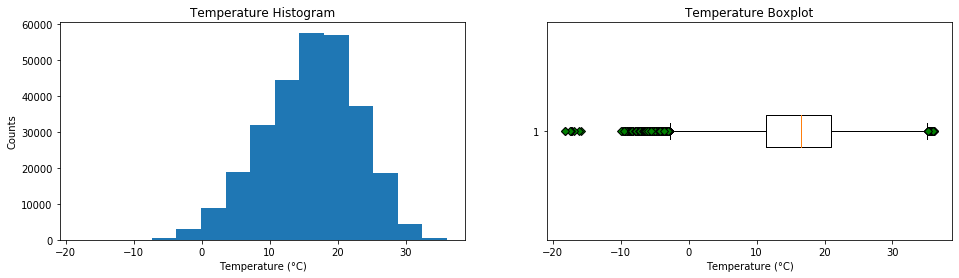

In [30]:
green_diamond = dict(markerfacecolor='g', marker='D')

fig, ax = plt.subplots(1, 2, figsize =(16,4))

ax[0].set_title('Temperature Histogram')
ax[0].hist(tmp, bins=15)
ax[0].set(xlabel='Temperature (°C)', ylabel='Counts')

ax[1].set_title('Temperature Boxplot')
ax[1].boxplot(tmp, vert = False, flierprops=green_diamond)
ax[1].set(xlabel='Temperature (°C)')

### Relative Humidity Histogram and Boxplot

In [31]:
rh = np.asarray([dataSet[key]['Rel Hum (%)'].values for key in dataSet]).flatten()
rh = rh[~np.isnan(rh)]

[Text(0.5, 0, 'Relative Humidity (%)')]

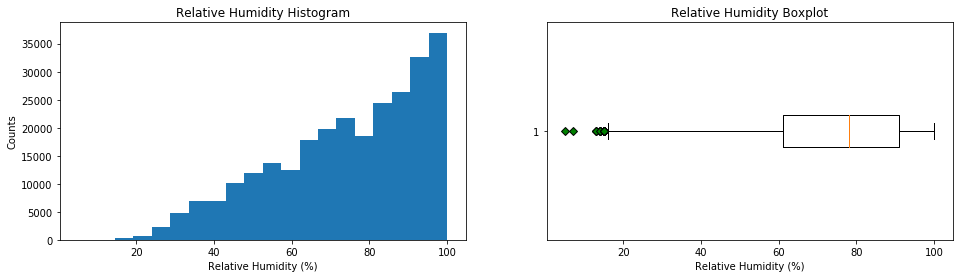

In [32]:
green_diamond = dict(markerfacecolor='g', marker='D')

fig, ax = plt.subplots(1, 2, figsize =(16,4))

ax[0].set_title('Relative Humidity Histogram')
ax[0].hist(rh, bins=20)
ax[0].set(xlabel='Relative Humidity (%)', ylabel='Counts')

ax[1].set_title('Relative Humidity Boxplot')
ax[1].boxplot(rh, vert = False, flierprops=green_diamond)
ax[1].set(xlabel='Relative Humidity (%)')